# Capstone Project - The Battle Of Neighborhoods

## Finding Better pace in Scarborough , Toronto

### 1, Installing and importing python libraries that we need

In [1]:
!pip install folium
!pip install geocoder

In [2]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import geocoder
import os
import json
import xml
import folium # map rendering library
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

from pandas.io.json import json_normalize 
from pandas import json_normalize
from sklearn.cluster import KMeans

print('Libraries imported.')

Libraries imported.


## 2. Scrape content from Wiki Page

### Getting Data

In [3]:
source = requests.get("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M")
soup = BeautifulSoup(source.text, 'lxml')

### Scrape the table and Data transformed into pandas DataFrame

In [4]:
table = soup.find('table',{'class':'wikitable sortable'})
table_rows = table.find_all('tr')
data= []
for row in table_rows:
    data.append([t.text.strip() for t in row.find_all('td')])

df = pd.DataFrame(data, columns=['PostalCode', 'Borough', 'Neighborhood'])
df = df[~df['PostalCode'].isnull()]
df.head(10)

,PostalCode,Borough,Neighborhood
1,M1A,Not assigned,Not assigned
2,M2A,Not assigned,Not assigned
3,M3A,North York,Parkwoods
4,M4A,North York,Victoria Village
5,M5A,Downtown Toronto,"Regent Park, Harbourfront"
6,M6A,North York,"Lawrence Manor, Lawrence Heights"
7,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"
8,M8A,Not assigned,Not assigned
9,M9A,Etobicoke,"Islington Avenue, Humber Valley Village"
10,M1B,Scarborough,"Malvern, Rouge"


### Data Cleanup

In [5]:
df.drop(df[df['Borough']=="Not assigned"].index,axis=0, inplace=True)
df.head(10)

,PostalCode,Borough,Neighborhood
3,M3A,North York,Parkwoods
4,M4A,North York,Victoria Village
5,M5A,Downtown Toronto,"Regent Park, Harbourfront"
6,M6A,North York,"Lawrence Manor, Lawrence Heights"
7,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"
9,M9A,Etobicoke,"Islington Avenue, Humber Valley Village"
10,M1B,Scarborough,"Malvern, Rouge"
12,M3B,North York,Don Mills
13,M4B,East York,"Parkview Hill, Woodbine Gardens"
14,M5B,Downtown Toronto,"Garden District, Ryerson"


Group all neighborhoods with the same postal code

In [6]:
df= df.groupby('PostalCode').agg(lambda x: ','.join(x))

#There are also cells that have an assigned neighbouhoods,like M7A, lets assign their boroughs as their neighbourhood, as follows:

df.loc[df['Neighborhood']=="Not assigned",'Neighborhood']=df.loc[df['Neighborhood']=="Not assigned",'Borough']
df=df.reset_index()
df['Borough']= df['Borough'].str.replace('nan|[{}\s]','').str.split(',').apply(set).str.join(',').str.strip(',').str.replace(",{2,}",",")
df.head(10)

,PostalCode,Borough,Neighborhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae
5,M1J,Scarborough,Scarborough Village
6,M1K,Scarborough,"Kennedy Park, Ionview, East Birchmount Park"
7,M1L,Scarborough,"Golden Mile, Clairlea, Oakridge"
8,M1M,Scarborough,"Cliffside, Cliffcrest, Scarborough Village West"
9,M1N,Scarborough,"Birch Cliff, Cliffside West"


Shape of the DataFrame

In [7]:
print("Shape : ",df.shape)

Shape :  (103, 3)


And its Summary

In [8]:
df.describe()

,PostalCode,Borough,Neighborhood
count,103,103,103
unique,103,10,99
top,M6A,NorthYork,Downsview
freq,1,24,4


In [9]:
def neighborhood_list(grouped):    
    return ', '.join(sorted(grouped['Neighborhood'].tolist()))
                    
grp = df.groupby(['PostalCode', 'Borough'])
df2 = grp.apply(neighborhood_list).reset_index(name='Neighborhood')

Summary of new DataFrame "df2"

In [10]:
df2.describe()

,PostalCode,Borough,Neighborhood
count,103,103,103
unique,103,10,99
top,M6A,NorthYork,Downsview
freq,1,24,4


### Getting Coordinates using Geocoder

In [11]:
def get_latilong(postal_code):
    lati_long_coords = None
    while(lati_long_coords is None):
        g = geocoder.arcgis('{}, Toronto, Ontario'.format(postal_code))
        lati_long_coords = g.latlng
    return lati_long_coords
    
get_latilong('M4G')

[43.70909000000006, -79.36409999999995]

In [12]:
# Retrieving Postal Code Co-ordinates
postal_codes = df2['PostalCode']    
coords = [ get_latilong(postal_code) for postal_code in postal_codes.tolist() ]

Adding Latitude and Longitude columns in DataFrame

In [13]:
df_coordnates = pd.DataFrame(coords, columns=['Latitude', 'Longitude'])
df2['Latitude'] = df_coordnates['Latitude']
df2['Longitude'] = df_coordnates['Longitude']

In [14]:
df2.head(10)

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.81153,-79.19552
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.78564,-79.15871
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.76575,-79.17520
3,M1G,Scarborough,Woburn,43.76820,-79.21761
4,M1H,Scarborough,Cedarbrae,43.76969,-79.23944
5,M1J,Scarborough,Scarborough Village,43.74309,-79.23526
6,M1K,Scarborough,"Kennedy Park, Ionview, East Birchmount Park",43.72861,-79.26367
7,M1L,Scarborough,"Golden Mile, Clairlea, Oakridge",43.71406,-79.28412
8,M1M,Scarborough,"Cliffside, Cliffcrest, Scarborough Village West",43.72360,-79.23496
9,M1N,Scarborough,"Birch Cliff, Cliffside West",43.69539,-79.26194


Summary of the DataFrame after coordinate adding columns

In [15]:
df2.describe(include="all")

,PostalCode,Borough,Neighborhood,Latitude,Longitude
count,103,103,103,103.000000,103.000000
unique,103,10,99,NaN,NaN
top,M6A,NorthYork,Downsview,NaN,NaN
freq,1,24,4,NaN,NaN
mean,NaN,NaN,NaN,43.705005,-79.394914
std,NaN,NaN,NaN,0.052309,0.094101
min,NaN,NaN,NaN,43.601080,-79.586240
25%,NaN,NaN,NaN,43.658650,-79.450935
50%,NaN,NaN,NaN,43.696230,-79.385960
75%,NaN,NaN,NaN,43.746200,-79.345605


In [16]:
address = 'Scarborough,Toronto'

geolocator = Nominatim(user_agent="toronto_explorer")
location = geolocator.geocode(address)
Latitude = location.latitude
Longitude = location.longitude
print('The Geograpical Co-ordinate of Seattle,Washington are {}, {}.'.format(Latitude, Longitude))

The Geograpical Co-ordinate of Seattle,Washington are 43.773077, -79.257774.


## 3. Map of Scarborough

In [17]:
map_Scarborough_toronto = folium.Map(location=[Latitude, Longitude], zoom_start=10)

for lat, lng, nei in zip(df2['Latitude'], df2['Longitude'], df2['Neighborhood']):
    
    label = '{}'.format(nei)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Scarborough_toronto)  
    
map_Scarborough_toronto

In [18]:
address = 'Scarborough,Toronto'

geolocator = Nominatim(user_agent="toronto_explorer")
location = geolocator.geocode(address)
latitude_n1 = location.latitude
longitude_n1 = location.longitude
print('The Geograpical Co-ordinate of Neighborhood_1 are {}, {}.'.format(Latitude, Longitude))

The Geograpical Co-ordinate of Neighborhood_1 are 43.773077, -79.257774.


In [19]:
CLIENT_ID = 'X5ID1JVJOF21I3BPEBMQRYTEZAZU4B5L2ICOHCUKHLZ1ZFXA'
CLIENT_SECRET = "IWZBZJXLZ4GOFHKNZMJNXZXCWOCBYT4JVJZ5LRXUWATCTCVD"
VERSION = "20200701"
LIMIT = 30

In [ ]:
radius = 700
LIMIT = 100
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude_n1, 
   longitude_n1, 
    radius, 
   LIMIT)
        
results = requests.get(url).json()

In [ ]:
venues=results['response']['groups'][0]['items']
nearby_venues = json_normalize(venues)
nearby_venues.columns

In [20]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

### 4. Nearby Venues and Locations

In [ ]:
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]
nearby_venues.head(10)

### 5. Categories of Nearby Venues and Locations

In [ ]:
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head(10)

In [ ]:
# Top 10 Categories
a=pd.Series(nearby_venues.categories)
a.value_counts()[:10]

In [21]:
def getNearbyVenues(names, latitudes, longitudes, radius=700):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # making GET request
        venue_results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in venue_results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [ ]:
# Nearby Venues
Scarborough_venues = getNearbyVenues(names=df2['Neighborhood'],
                                   latitudes=df2['Latitude'],
                                   longitudes=df2['Longitude']
                                  )

In [ ]:
print('There are {} Uniques Categories.'.format(len(Scarborough_venues['Venue Category'].unique())))
Scarborough_venues.groupby('Neighborhood').count().head()

### OneHot Encoding of Features

In [ ]:
# one hot encoding
Scarborough_onehot = pd.get_dummies(Scarborough_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Scarborough_onehot['Neighborhood'] = Scarborough_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [Scarborough_onehot.columns[-1]] + list(Scarborough_onehot.columns[:-1])
Scarborough_onehot = Scarborough_onehot[fixed_columns]
Scarborough_grouped = Scarborough_onehot.groupby('Neighborhood').mean().reset_index()
Scarborough_onehot.head(5)

In [ ]:
num_top_venues = 5
for hood in Scarborough_grouped['Neighborhood']:
    print("---- "+hood+" ----")
    temp =Scarborough_grouped[Scarborough_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

### Most Common Venues Near Neighborhood

In [ ]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [ ]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = Scarborough_grouped['Neighborhood']

for ind in np.arange(Scarborough_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Scarborough_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

### 6. K-Means Clustering

In [ ]:
# Using K-Means to cluster neighborhood into 5 clusters
Scarborough_grouped_clustering = Scarborough_grouped.drop('Neighborhood', 1)
kmeans = KMeans(n_clusters=5, random_state=0).fit(Scarborough_grouped_clustering)
kmeans.labels_

In [ ]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

Scarborough_merged =df2.iloc[:16,:]

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
Scarborough_merged = Scarborough_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

Scarborough_merged# check the last columns!

Map of Clusters

In [ ]:
kclusters = 10
# create map
map_clusters = folium.Map(location=[Latitude, Longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
colors_array = cm.rainbow(np.linspace(0, 1, kclusters))
rainbow = [colors.rgb2hex(i) for i in colors_array]
# add markers to the map

markers_colors = []
for lat, lon, nei , cluster in zip(Scarborough_merged['Latitude'], 
                                   Scarborough_merged['Longitude'], 
                                   Scarborough_merged['Neighborhood'], 
                                   Scarborough_merged['Cluster Labels']):
    label = folium.Popup(str(nei) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [ ]:
cls1=Scarborough_merged.loc[Scarborough_merged['Cluster Labels'] == 0,Scarborough_merged.columns[[2] + list(range(5, Scarborough_merged.shape[1]))]]
cls2=Scarborough_merged.loc[Scarborough_merged['Cluster Labels'] == 1,Scarborough_merged.columns[[2] + list(range(5, Scarborough_merged.shape[1]))]]
cls3=Scarborough_merged.loc[Scarborough_merged['Cluster Labels'] == 2,Scarborough_merged.columns[[2] + list(range(5, Scarborough_merged.shape[1]))]]
cls4=Scarborough_merged.loc[Scarborough_merged['Cluster Labels'] == 3,Scarborough_merged.columns[[2] + list(range(5, Scarborough_merged.shape[1]))]]
cls5=Scarborough_merged.loc[Scarborough_merged['Cluster Labels'] == 4,Scarborough_merged.columns[[2] + list(range(5, Scarborough_merged.shape[1]))]]

In [22]:
df2.describe(include="all")

,PostalCode,Borough,Neighborhood,Latitude,Longitude
count,103,103,103,103.000000,103.000000
unique,103,10,99,NaN,NaN
top,M6A,NorthYork,Downsview,NaN,NaN
freq,1,24,4,NaN,NaN
mean,NaN,NaN,NaN,43.705005,-79.394914
std,NaN,NaN,NaN,0.052309,0.094101
min,NaN,NaN,NaN,43.601080,-79.586240
25%,NaN,NaN,NaN,43.658650,-79.450935
50%,NaN,NaN,NaN,43.696230,-79.385960
75%,NaN,NaN,NaN,43.746200,-79.345605


## Average Housing Price of the Neighborhood

In [33]:
Scarborough_Avg_HousingPrice=pd.DataFrame({"Neighborhood":df2["Neighborhood"],
                                      "Average_Housing_Price":[335000.0,286600.0,175000.0,225900.0,219400.0,
                                                               573900.0,225000.0,370500.0,370500.0,433500.0,279200.0,
                                                               279200.0,225000.0,370500.,255400.0,433500.0,433500.0,
                                                               435000.0,289500.0,265000.0,285900.0,239400.0,
                                                               589900.0,295000.0,380500.0,378500.0,438500.0,229200.0,
                                                               229200.0,365000.0,388500.,285400.0,493500.0,477500.0,378000.0,316600.0,195000.0,225900.0,219400.0,
                                                               573900.0,367000.0,370500.0,370500.0,363500.0,279200.0,
                                                               279200.0,271000.0,370500.,255400.0,383500.0,433500.0,335000.0,286600.0,185000.0,225900.0,219400.0,
                                                               573900.0,329000.0,370500.0,370500.0,533500.0,279200.0,
                                                               279200.0,375000.0,370500.,255400.0,493500.0,433500.0,335000.0,286600.0,165000.0,225900.0,219400.0,
                                                               573900.0,425000.0,370500.0,370500.0,433500.0,279200.0,
                                                               279200.0,195000.0,370500.,255400.0,403500.0,433500.0,335000.0,286600.0,187000.0,225900.0,219400.0,
                                                               573900.0,325000.0,370500.0,370500.0,333500.0,279200.0,
                                                               279200.0,289000.0,370500.,255400.0,413500.0,433500.0,254800.0
                                                              
                                                              
                                                              ]})

### bar chart for average housing prices

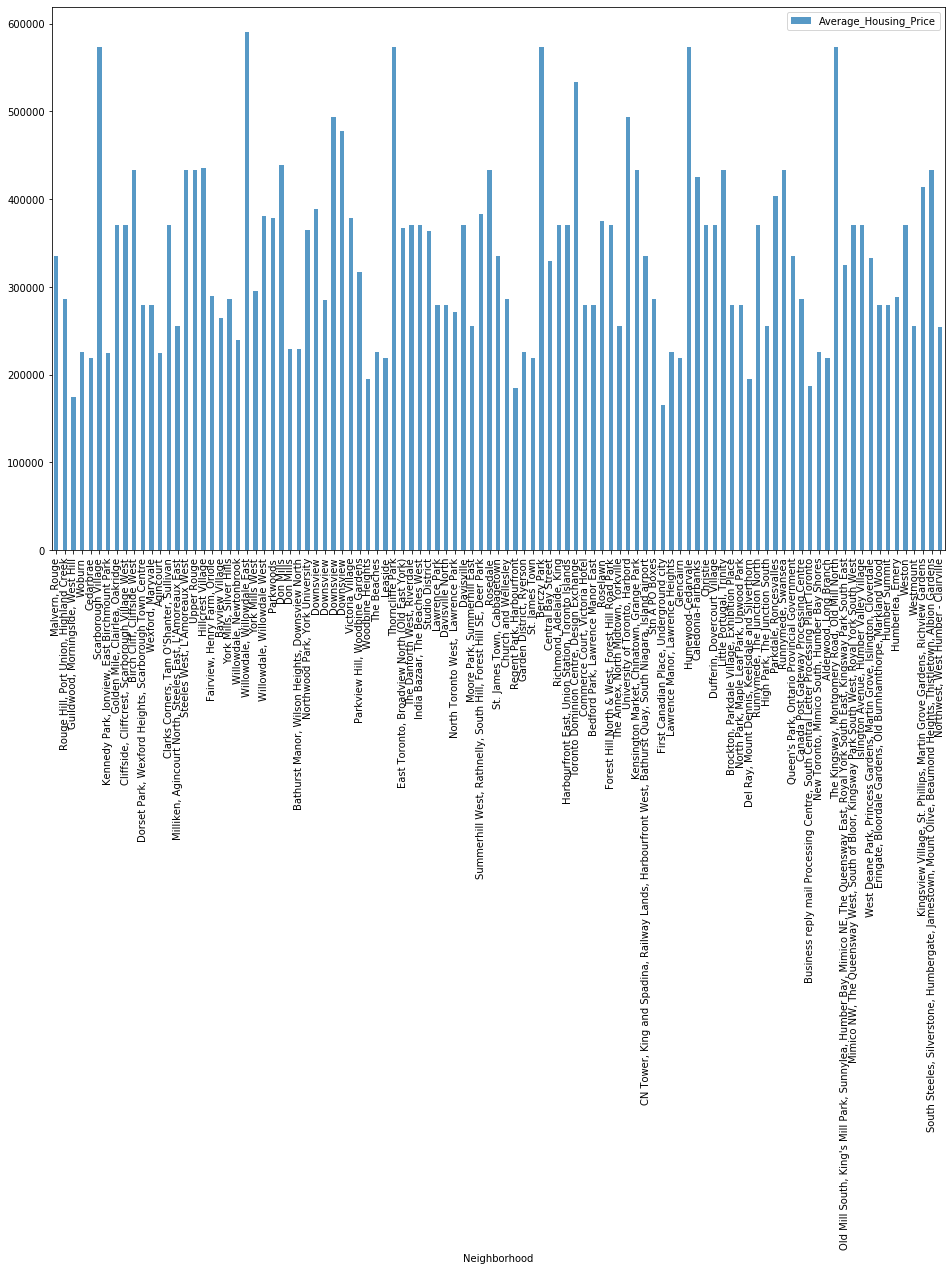

In [34]:
Scarborough_Avg_HousingPrice.set_index('Neighborhood',inplace=True,drop=True)
Scarborough_Avg_HousingPrice.plot(kind='bar',figsize=(16,10),alpha=0.75)

In [ ]:
clusters=pd.DataFrame({"Cluster1":cls1["Neighborhood"],
                      "Cluster2":cls2["Neighborhood"],
                      "Cluster3":cls3["Neighborhood"],
                      "Cluster4":cls4["Neighborhood"],
                      "Cluster5":cls5["Neighborhood"]})
clusters = clusters.replace(np.nan, '', regex=True)

## Rating of schools of Neighborhood

In [31]:
##new_Scarborough=Scarborough_merged.set_index("Neighborhood",drop=True)
#Source:https://www.greatschools.org
Scarborough_school_ratings=pd.DataFrame({"Neighborhood":df["Neighborhood"],
                                      "Top School Rating":[7,9,5,8,10,10,7,10,1,2,1,2,7,2,3,2,6,
                                                           5,4,8,9,9,6,6,4,5,4,6,8,10,8,9,6,2,
                                                           10,2,5,8,9,6,6,10,8,9,1,2,3,4,5,6,9,
                                                           8,5,9,6,9,6,4,8,10,2,5,6,3,9,8,7,
                                                           7,8,5,8,9,1,5,4,7,2,3,6,6,9,4,8,7,
                                                           4,8,9,2,6,4,7,5,10,4,6,8,9,7,5,6,5,8,7
                                                           ]})

### Bar chart for the list of rating of Schools

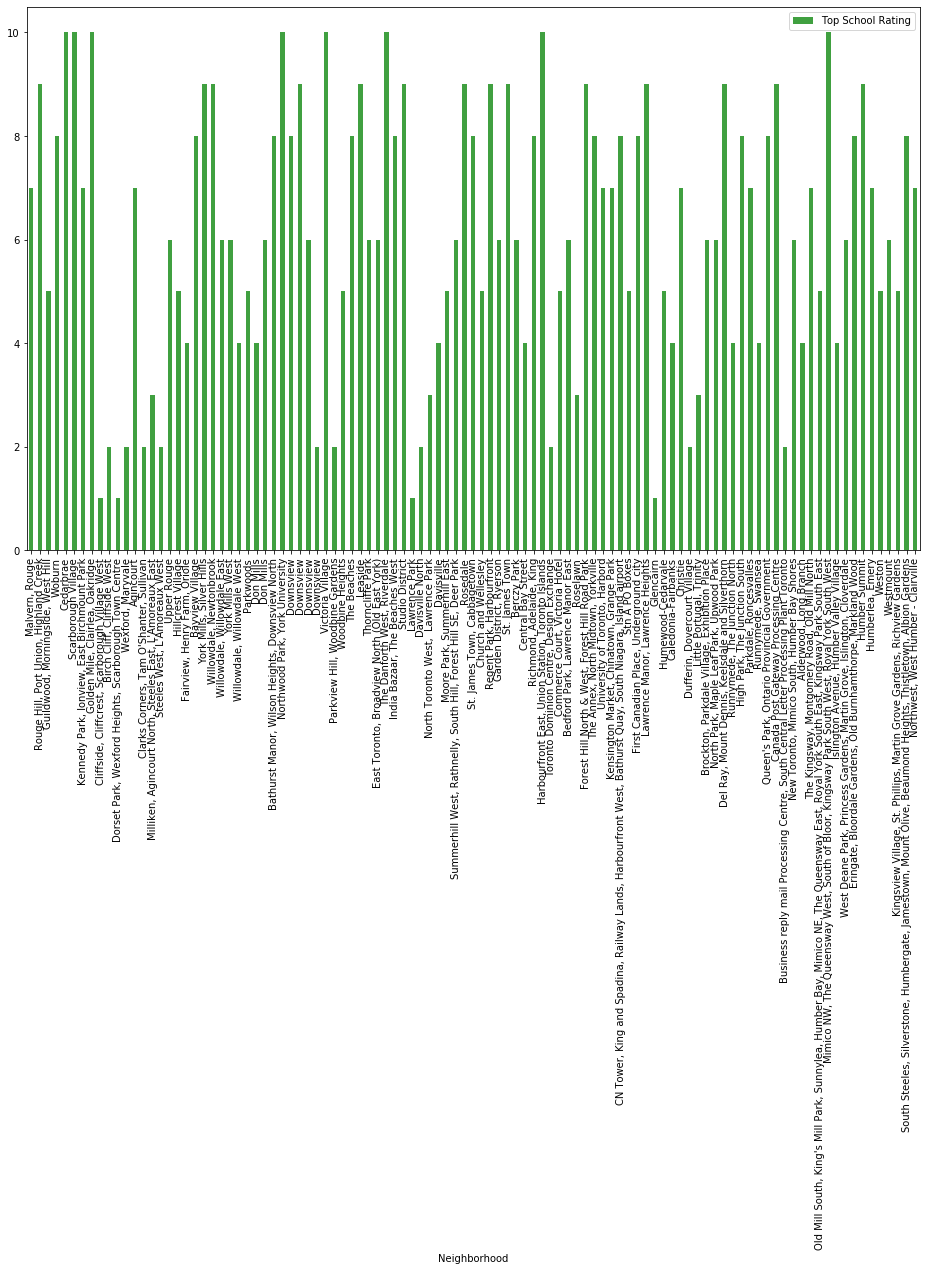

In [32]:
Scarborough_school_ratings.set_index('Neighborhood',inplace=True,drop=True)
Scarborough_school_ratings.plot(kind='bar',figsize=(16,10),color='green',alpha=0.75);

## Rating of Restuarants in Neighborhood

In [27]:
##new_Scarborough=Scarborough_merged.set_index("Neighborhood",drop=True)
Scarborough_restuarant_ratings=pd.DataFrame({"Neighborhood":df["Neighborhood"],
                                      "Top Restaurant Rating":[9,6,5,8,1,6,7,10,1,2,1,2,7,2,3,2,6,
                                                           5,4,8,9,9,6,6,4,3,4,6,6,10,8,9,6,2,
                                                           3,2,5,8,9,6,6,10,8,9,10,2,3,4,5,6,9,
                                                           7,5,9,6,9,6,4,8,10,2,8,6,3,9,8,7,
                                                           8,8,5,8,9,1,5,4,7,2,3,6,6,9,4,8,7,
                                                           4,8,9,10,6,4,7,5,10,4,6,8,9,7,5,6,5,8,7
                                                           ]})

### Bar chart of rating of Restuarants in Neighborhood

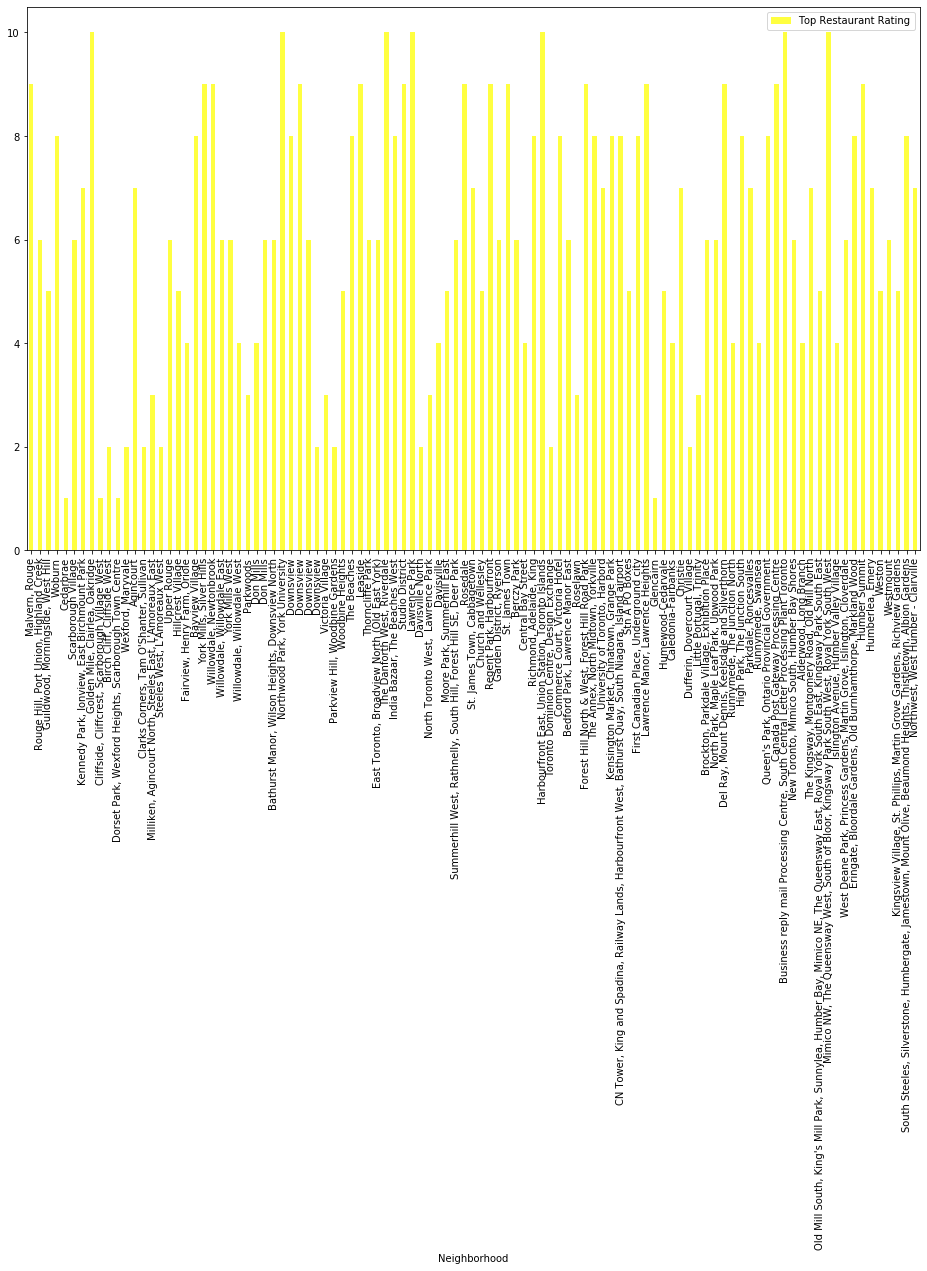

In [28]:
Scarborough_restuarant_ratings.set_index('Neighborhood',inplace=True,drop=True)
Scarborough_restuarant_ratings.plot(kind='bar',figsize=(16,10),color='yellow',alpha=0.75);